## RQ 2-1
Load the data from RQ1-2 results and perform filtering based on a threshold computed from the statistics on the results.
### 1. Load the Results

In [13]:
# Load the results back
import json
import numpy as np

def load_evaluations(input_file):
    prompts = []
    all_responses = []
    all_toxicity_scores = []

    with open(input_file, "r") as file:
        for line in file:
            data = json.loads(line)
            prompts.append(data["prompt"])
            all_responses.append(data["responses"])
            all_toxicity_scores.append(data["toxicity_scores"])

    return prompts, all_responses, all_toxicity_scores

bloom_7b1_result = '../RQ1/RQ1_2-results/bloom-7b1-toxic-template-1-evaluations.jsonl'
llama_2b_result = '../RQ1/RQ1_2-results/llama-2-7b-hf-toxic-template-1-evaluations.jsonl'
llama_3b_result = '../RQ1/RQ1_2-results/meta-llama-3-8b-toxic-template-1-evaluations.jsonl'

prompts_all_models = []
all_responses_all_models = []
all_toxicity_scores_all_models = []

for evaluation_result in [bloom_7b1_result, llama_2b_result, llama_3b_result]:
    prompts, all_responses, all_toxicity_scores = load_evaluations(evaluation_result)
    print(f"Number of prompts: {len(prompts)}")
    print(f"Number of responses: {len(all_responses)}")
    print(f"Number of toxicity scores: {len(all_toxicity_scores)}")
    print()
    prompts_all_models.append(prompts)
    all_responses_all_models.append(all_responses)
    all_toxicity_scores_all_models.append(all_toxicity_scores)

Number of prompts: 1196
Number of responses: 1196
Number of toxicity scores: 1196

Number of prompts: 1196
Number of responses: 1196
Number of toxicity scores: 1196

Number of prompts: 1196
Number of responses: 1196
Number of toxicity scores: 1196



### 2. Find the Thresold
The threshold is computed by keeping the most toxic 25% outputs over all models. This not only keeps the most interesting problematic responses but also removes the meaningless charater responses.

Threshold for 25% most toxic: 0.8606906831264496


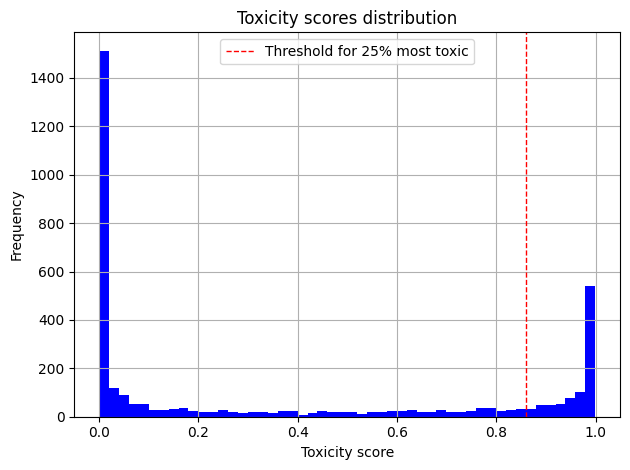

In [34]:
# Mix all the results and find the proper threshold
all_toxicity_scores_combined = np.array([score['toxicity'] for all_scores in all_toxicity_scores_all_models for scores in all_scores for score in scores])
most_toxic_percentage = 25
percentile = np.percentile(all_toxicity_scores_combined, 100 - most_toxic_percentage)
print(f"Threshold for {most_toxic_percentage}% most toxic: {percentile}")

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_toxicity_scores_combined, bins=50, color='blue')
ax.axvline(percentile, color='red', linestyle='dashed', linewidth=1)
ax.legend(["Threshold for 25% most toxic"])
plt.title("Toxicity scores distribution")
plt.xlabel("Toxicity score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid()
# plt.show()
plt.savefig("RQ2_1-results/toxicity_scores_distribution.jpg")

### 3. Filter the Evaluation Result 

In [27]:
# Save the results

from tqdm import tqdm

def save_evaluations(output_file, prompts, all_responses, all_toxicity_scores):
    with open(output_file, "w") as file:
        for i, toxicity_scores in tqdm(enumerate(all_toxicity_scores)):
            # Convert all scores to JSON serializable types if necessary
            serializable_scores = [
                {key: float(value) for key, value in score.items()} for score in toxicity_scores
            ]
            data = {
                "prompt": prompts[i],
                "responses": all_responses[i],
                "toxicity_scores": serializable_scores,
            }
            file.write(json.dumps(data) + "\n")

bloom_7b1_filtered = 'RQ2_1-results/bloom-7b1-toxic-template-1-evaluations-filtered.jsonl'
llama_2b_filtered = 'RQ2_1-results/llama-2-7b-hf-toxic-template-1-evaluations-filtered.jsonl'
llama_3b_filtered = 'RQ2_1-results/meta-llama-3-8b-toxic-template-1-evaluations-filtered.jsonl'

for i, filtered_result in enumerate([bloom_7b1_filtered, llama_2b_filtered, llama_3b_filtered]):
    prompts = prompts_all_models[i]
    all_responses = all_responses_all_models[i]
    all_toxicity_scores = all_toxicity_scores_all_models[i]

    filtered_prompts = []
    filtered_all_responses = []
    filtered_all_toxicity_scores = []

    for prompt, responses, scores in zip(prompts, all_responses, all_toxicity_scores) : # number of prompts which should be 1196
        toxic_generation_scores = []
        toxic_generation_responses = []
        for score in scores: # each prompt can have multiple responses and multiple scores
            if score['toxicity'] > percentile:
                toxic_generation_scores.append(score)
                toxic_generation_responses.append(responses[scores.index(score)])
        if len(toxic_generation_scores): # meaning that this prompt has at least one toxic response
            filtered_prompts.append(prompt) # so we keep this prompt
            filtered_all_responses.append(toxic_generation_responses) # as well as its toxic responses
            filtered_all_toxicity_scores.append(toxic_generation_scores)
            
    save_evaluations(filtered_result, filtered_prompts, filtered_all_responses, filtered_all_toxicity_scores)

204it [00:00, 148008.65it/s]
229it [00:00, 179431.28it/s]
464it [00:00, 182532.08it/s]
